# Analyze the HNN toy task

In [2]:
import torch, time, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-toy'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_field
from nn_models import MLP
from hnn import HNN
from utils import L2_loss

## Set some notebook constants

In [7]:
DPI = 120
FORMAT = 'png'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 1000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'toy',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Inspect the toy dataset

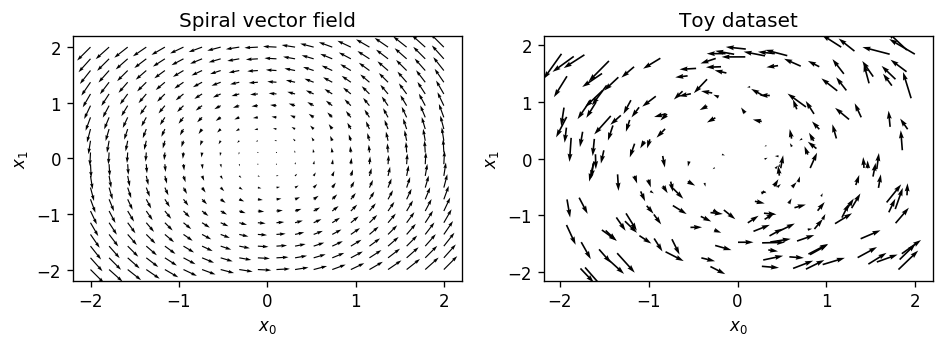

In [8]:
field, data = get_field(), get_dataset()

# plot config
fig = plt.figure(figsize=(8, 3), facecolor='white', dpi=DPI)

# plot spiral vector field
ax = fig.add_subplot(1, 2, 1, frameon=True)
ax.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1], cmap='gray_r' )
ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
ax.set_title("Spiral vector field")

# plot dataset
ax = fig.add_subplot(1, 2, 2, frameon=True)
ax.quiver(data['x'][:,0], data['x'][:,1], data['dx'][:,0], data['dx'][:,1], cmap='gray_r' )
ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
ax.set_title("Toy dataset")

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/toy-task.png')

## Construct models

In [9]:
def get_model(args, baseline):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'hnn'
    path = "{}/toy{}-{}.tar".format(args.save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    return model

## Get vector fields

In [10]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

## Integrate along vector fields

In [11]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Run analysis

In [12]:
args = ObjectView(get_args())
base_model = get_model(args, baseline=True)
hnn_model = get_model(args, baseline=False)

# get their vector fields
field = get_field(gridsize=args.gridsize)
data = get_dataset()
base_field = get_vector_field(base_model, gridsize=args.gridsize)
hnn_field = get_vector_field(hnn_model, gridsize=args.gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,30]
y0 = np.asarray([1.5, 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000)}
base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)

## Plot results

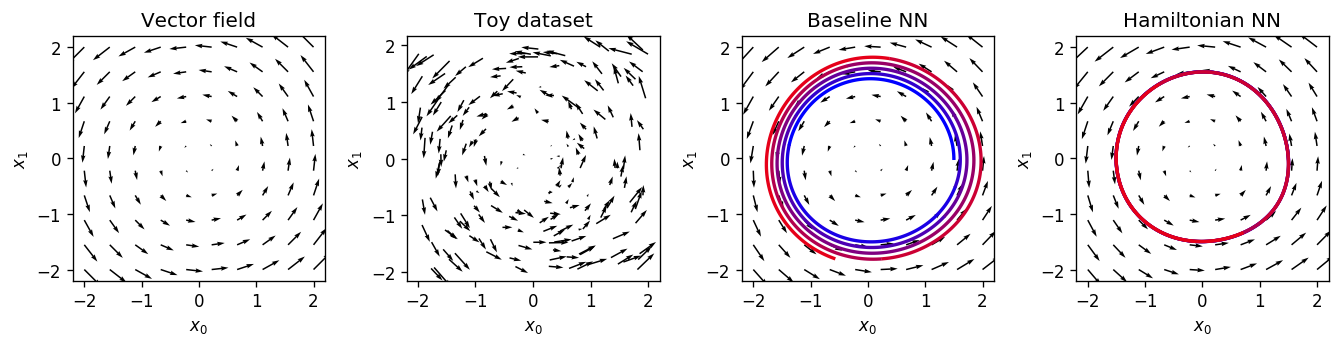

In [13]:
###### PLOT ######
fig = plt.figure(figsize=(11.3, 3), facecolor='white', dpi=DPI)

# plot vector field
ax = fig.add_subplot(1, 4, 1, frameon=True)
ax.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH)  
ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
ax.set_title("Vector field")

# plot dataset
ax = fig.add_subplot(1, 4, 2, frameon=True)
ax.quiver(data['x'][:,0], data['x'][:,1], data['dx'][:,0], data['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH)  
ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
ax.set_title("Toy dataset")

# plot baseline
ax = fig.add_subplot(1, 4, 3, frameon=True)
ax.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH)

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    ax.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
ax.set_title("Baseline NN")

# plot HNN
ax = fig.add_subplot(1, 4, 4, frameon=True)
ax.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH)

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    ax.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
ax.set_title("Hamiltonian NN")

plt.tight_layout() ; plt.show()
fig.savefig('{}/toy{}.{}'.format(args.fig_dir, RK4, FORMAT))